<a href="https://colab.research.google.com/github/yahal2005/Facial-Emotion-Recognition/blob/2-dt-classifiers-on-ck-dataset-lbp/facial_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/Colab_Notebooks/fer'

In [ ]:
haarcascade_path = os.path.join(base_path, 'haarcascade_frontalface_default.xml')
face_cascade = cv2.CascadeClassifier(haarcascade_path)

In [ ]:
def load_and_detect_faces(folder_path):
  images = []
  labels = []
  for label in os.listdir(folder_path):
    label_path = os.path.join(folder_path, label)
    if os.path.isdir(label_path):
      for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
          faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
          for (x, y, w, h) in faces:
            face_region = img[y:y+h, x:x+w]
            images.append(face_region)
            labels.append(label)
  return images,labels

In [ ]:
radius = 1
n_points = 8 * radius

def extract_lbp_features(images):
  lbp_features = []
  for image in images:
    img = cv2.resize(image, (64, 64))
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    (hist,_) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    lbp_features.append(hist)
  return np.array(lbp_features)

In [ ]:
train_folder_path = os.path.join(base_path, 'CK_dataset/train')
test_folder_path = os.path.join(base_path, 'CK_dataset/test')

X_train_faces, y_train = load_and_detect_faces(train_folder_path)
X_train_features = extract_lbp_features(X_train_faces)

X_test_faces, y_test = load_and_detect_faces(test_folder_path)
X_test_features = extract_lbp_features(X_test_faces)

In [ ]:
tree_classifier = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_classifier.fit(X_train_features, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [ ]:
y_pred = tree_classifier.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 35.66%
Confusion Matrix:
[[ 2  1  3  8  3  1]
 [ 0  0  1  4  2  0]
 [ 2  1 10  9  1  7]
 [ 5  1  7 20  2  1]
 [ 2  1  5  5  3  1]
 [ 0  0  7  9  3 16]]


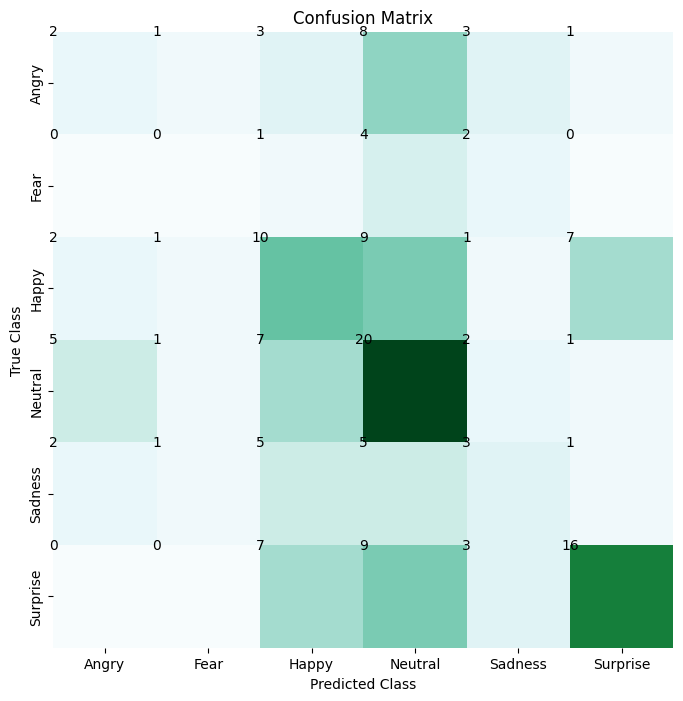

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

class_names = ["Angry", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1,keepdims=True) * 100

plt.figure(figsize=(8, 8))
ax = sns.heatmap(conf_matrix, annot=False, cmap="BuGn", xticklabels=class_names, yticklabels=class_names,cbar=False)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count = conf_matrix[i, j]
        ax.text(j, i, f"{count}", ha="center", va="center", color="black", fontsize=10)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

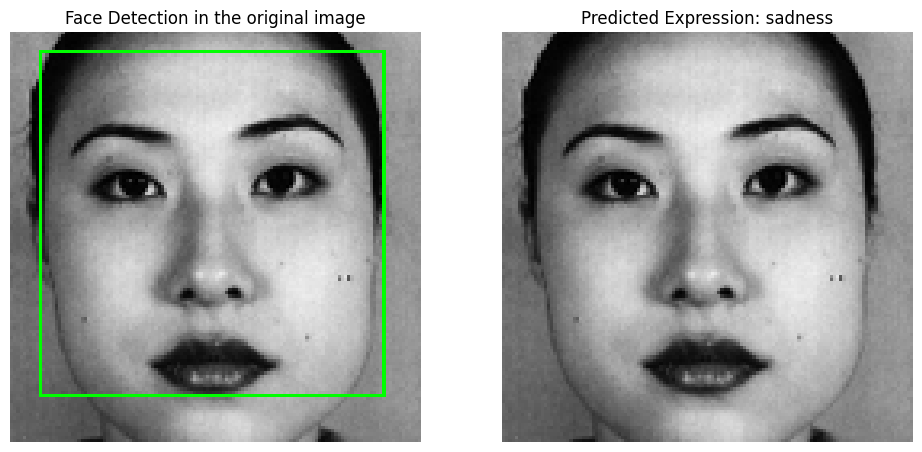

In [ ]:
def predict_emotion(image_path, model):
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  if img is None:
    raise ValueError(f"Failed to load image from {image_path}")

  faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
  if len(faces) == 0:
    print("No face detected.")
    return

  for (x, y, w, h) in faces:
    face_region = img[y:y+h, x:x+w]
    face_region = cv2.resize(face_region, (64, 64))
    lbp = local_binary_pattern(face_region, n_points, radius, method="uniform")

    hist,_ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)

    features = hist.reshape(1,-1)
    predicted_expression = model.predict(features)[0]

    img_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    img_with_box = img_rgb.copy()
    cv2.rectangle(img_with_box, (x, y), (x+w, y+h), (0, 255, 0), 1)
    plt.figure(figsize=(18, 6))


    plt.subplot(1,3,1)
    plt.imshow(img_with_box)
    plt.title(f"Face Detection in the original image")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(img_rgb)
    plt.title(f"Predicted Expression: {predicted_expression}")
    plt.axis('off')

    plt.show()

image_path = os.path.join(base_path, 'testimages/24.tiff')
predict_emotion(image_path, tree_classifier)